In [152]:
# Setting up the dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("dataset/features_3_sec.csv").drop(columns=["filename", "length"])
label_to_id = {label : id for id, label in enumerate(sorted(df["label"].unique()))}
print(label_to_id)
df["label_id"] = df["label"].map(label_to_id)
df_train, df_test = train_test_split(
    df, test_size=0.10, stratify=df["label"]
)

x_train = df_train.drop(columns=["label", "label_id"]).to_numpy()
y_train = df_train["label_id"].to_numpy()
x_test = df_test.drop(columns=["label", "label_id"]).to_numpy()
y_test = df_test["label_id"].to_numpy()
# normalize
mu = x_train.mean(axis=0)
sigma = x_train.std(axis=0) + 1e-8
x_train = (x_train - mu) / sigma
x_test  = (x_test  - mu) / sigma

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [119]:
class NeuralNet:
    def __init__(self, input_size, output_size,
                 hidden_layer_1_size, hidden_layer_2_size,
                 learning_rate):
        in_dim = input_size
        out = output_size
        h1 = hidden_layer_1_size
        h2 = hidden_layer_2_size

        self.W0 = np.random.randn(h1, in_dim) * np.sqrt(2/in_dim)
        self.W1 = np.random.randn(h2, h1)     * np.sqrt(2/h1)
        self.W2 = np.random.randn(out, h2)    * np.sqrt(2/h2)
        self.b0 = np.zeros(h1)
        self.b1 = np.zeros(h2)
        self.b2 = np.zeros(out)

        # initialize layers for caching
        self.L1 = np.zeros(hidden_layer_1_size)
        self.L2 = np.zeros(hidden_layer_2_size)
        # learning rate
        self.lr = learning_rate
        
    def softmax(self, array):
        # Subtract max per row for numerical stability
        exps = np.exp(array - np.max(array, axis=-1, keepdims=True))
        return exps / exps.sum(axis=-1, keepdims=True)
    
    def ReLU(self, x):
        return (x > 0) * x
    
    def feed_forward(self, input):
        self.L1 = self.ReLU(self.W0 @ input + self.b0)
        self.L2 = self.ReLU(self.W1 @ self.L1 + self.b1)
        output = self.softmax(self.W2 @ self.L2 + self.b2)
        return output
    
    def backward_pass(self, input, pred, true_one_hot):
        # CALCULATE GRADIENTS
        # ce loss = -/sum_i (true_i * log(pred_i))
        # since one-hot encoded, just leads to cel = -log(pred_true)
        # epsilon to avoid floating errors
        epsilon = 1e-12
        ce_loss = -np.log(pred[np.argmax(true_one_hot)] + epsilon)
        # gradient simplifies due to cel
        pre_softmax_grad = pred - true_one_hot
        # db2/psg = 1
        db2 = pre_softmax_grad
        # dW2/psg (still unclear - outer product because of singular weight updates?)
        dW2 = np.outer(pre_softmax_grad, self.L2)
        dL2 = self.W2.T @ pre_softmax_grad * (self.L2 > 0)
        db1 = dL2
        dW1 = np.outer(dL2, self.L1)
        dL1 = self.W1.T @ dL2 * (self.L1 > 0)
        db0 = dL1
        dW0 = np.outer(dL1, input)
        
        # ADJUST WEIGHTS
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W0 -= self.lr * dW0
        self.b0 -= self.lr * db0
        
        return ce_loss
        
    def train(self, x_train, y_train, epochs):
        losses = []
        for epoch in range(epochs):
            loss = 0
            for x, y in zip(x_train, y_train):
                y_ohe = np.zeros(len(label_to_id))
                y_ohe[y] = 1
                pred = self.feed_forward(x)
                loss += self.backward_pass(x, pred, y_ohe)
                loss += loss / len(y_train)
            losses.append(loss)
        return losses

In [168]:
nn = NeuralNet(input_size=x_train.shape[1],
               output_size=len(label_to_id),
               hidden_layer_1_size=32,
               hidden_layer_2_size=16,
               learning_rate=1e-3)
losses = nn.train(x_train, y_train, epochs=40)

In [178]:

# open a csv file and load its first non-header row into the network
with open("balls.csv", "r") as f:
    header = f.readline().strip().split(",")
    first_data_row = f.readline().strip().split(",")
    first_data_row = [float(x) for x in first_data_row[2:-1]]  # skip filename and length
    # Normalize the first_data_row using mu and sigma from training data
    first_data_row = (np.array(first_data_row) - mu) / sigma
    pred = nn.feed_forward(np.array(first_data_row))

# reverse label_to_id mapping
id_to_label = {id: label for label, id in label_to_id.items()}
pred_label = id_to_label[int(np.argmax(pred))]
print(f"Predicted label for first data row in balls.csv: {pred_label}")


Predicted label for first data row in balls.csv: rock


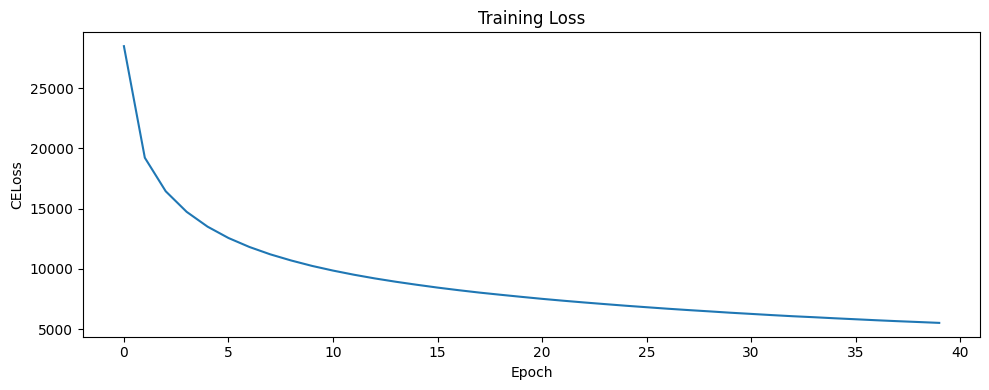

In [169]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("CELoss")
plt.title("Training Loss")
plt.tight_layout()
# plt.savefig("training_loss.png")